In [36]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
# import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor,plot_importance
from scipy.stats import f_oneway
import pandas as pd

In [37]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

# 평균인코딩

### 데이터 전처리

In [38]:
past_sales = pd.read_csv('C:/Users/PC/표/수요예측/rossmann-store-sales/train.csv')
store = pd.read_csv('C:/Users/PC/표/수요예측/rossmann-store-sales/store.csv')

past_sales['Date'] = pd.to_datetime(past_sales['Date'], format="%Y-%m-%d") # 년도, 달, 일 순으로 format
# a = 공휴일, b = 부활절 공휴일, c = 크리스마스, d = 없음
past_sales['StateHoliday'] = past_sales['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
past_sales['StateHoliday'] = past_sales['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체
past_sales = past_sales.sort_values('Date') # date 기준으로 정렬
# past_sales = pd.get_dummies(data = past_sales,columns=['StateHoliday']) # StateHoliday를 더미 가변수로 대체, 결측값 없다는 거 확인 완료

store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)
# store = pd.get_dummies(data = store, columns = ['Assortment']) # 규모를 더미 가변수로 대체, storetype = a에는 규모가 b인 상점은 없음

# 결측값 확인 : past_sales.isnull().sum(), store_a.isnull().sum()
# store의 CompetitionDistance에 3개 있음
# 결측값 : 평균으로 대체
store['CompetitionDistance'] = store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean())

# 병합
data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')
# data = pd.get_dummies(data = data, columns = ['DayOfWeek']) # 요일 더미의 가변수로 추가
# data = pd.get_dummies(data = data, columns = ['StoreType'])
data['Month']=pd.DatetimeIndex(data.Date).month
data['Day']=pd.DatetimeIndex(data.Date).day
data = data.drop(['Date'],axis=1) # 그래프 그릴려고 잠시 제거한 코드

pd.options.display.max_columns = None

C:\Users\PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [39]:
StoreType_mean = data.groupby("StoreType")["Sales"].mean()
data.loc[data['StoreType'] == 'a', 'StoreType'] = StoreType_mean[0]
data.loc[data['StoreType'] == 'b', 'StoreType'] = StoreType_mean[1]
data.loc[data['StoreType'] == 'c', 'StoreType'] = StoreType_mean[2]
data.loc[data['StoreType'] == 'd', 'StoreType'] = StoreType_mean[3]

StateHoliday_mean = data.groupby("StateHoliday")["Sales"].mean()
data.loc[data['StateHoliday'] == 'a', 'StateHoliday'] = StateHoliday_mean[0]
data.loc[data['StateHoliday'] == 'b', 'StateHoliday'] = StateHoliday_mean[1]
data.loc[data['StateHoliday'] == 'c', 'StateHoliday'] = StateHoliday_mean[2]
data.loc[data['StateHoliday'] == 'd', 'StateHoliday'] = StateHoliday_mean[3]

Assortment_mean = data.groupby("Assortment")["Sales"].mean()
data.loc[data['Assortment'] == 'a', 'Assortment'] = Assortment_mean[0]
data.loc[data['Assortment'] == 'b', 'Assortment'] = Assortment_mean[1]
data.loc[data['Assortment'] == 'c', 'Assortment'] = Assortment_mean[2]

In [40]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)        
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
features = features.values
target = target.values
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=34)
x_test,x_valid,y_test,y_valid = train_test_split(x_test, y_test, test_size=0.5)

In [41]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_valid = x_valid.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
y_valid = y_valid.astype(np.float32)

In [42]:
print('train_data의 row : %s, column : %s'%(x_train.shape[0],x_train.shape[1]))
print('test_data의 row : %s, column : %s'%(x_test.shape[0],x_test.shape[1]))
print('val_data의 row : %s, column : %s'%(x_valid.shape[0],x_valid.shape[1]))

train_data의 row : 813767, column : 13
test_data의 row : 101721, column : 13
val_data의 row : 101721, column : 13


### 학습

In [43]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,input_dim = x_train.shape[1],activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(256,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(256,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
             loss='mse',
             metrics=['mean_absolute_error'])

model_path = 'C:/project/rossmann-store-sales'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path , monitor='val_mean_absolute_error', verbose=1, save_best_only=True)
# early_stopping = EarlyStopping(monitor='val_loss', patience=6)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               3584      
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_12 (Dense)             (None, 256)              

In [44]:
import datetime

In [45]:
start = datetime.datetime.now()
results= model.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid),
                    batch_size=64,
                    epochs=50,
                   callbacks=[checkpoint])
end = datetime.datetime.now()
time = end-start
print("처리시간 : ", time)

Epoch 1/50
12707/12716 [============================>.] - ETA: 0s - loss: 11580971.0000 - mean_absolute_error: 2270.4272
Epoch 00001: val_mean_absolute_error improved from inf to 1128.49951, saving model to C:/project\rossmann-store-sales
INFO:tensorflow:Assets written to: C:/project\rossmann-store-sales\assets
12716/12716 [==============================] - 121s 10ms/step - loss: 11575048.0000 - mean_absolute_error: 2269.6414 - val_loss: 193055888.0000 - val_mean_absolute_error: 1128.4995
Epoch 2/50
12713/12716 [============================>.] - ETA: 0s - loss: 1943864.6250 - mean_absolute_error: 1011.0164
Epoch 00002: val_mean_absolute_error did not improve from 1128.49951
12716/12716 [==============================] - 110s 9ms/step - loss: 1943904.5000 - mean_absolute_error: 1011.0117 - val_loss: 222685069312.0000 - val_mean_absolute_error: 4074.2605
Epoch 3/50
12712/12716 [============================>.] - ETA: 0s - loss: 1794479.1250 - mean_absolute_error: 972.0615
Epoch 00003: val

Epoch 23/50
12713/12716 [============================>.] - ETA: 0s - loss: 1587571.6250 - mean_absolute_error: 913.8385
Epoch 00023: val_mean_absolute_error did not improve from 1128.49951
12716/12716 [==============================] - 108s 8ms/step - loss: 1587701.1250 - mean_absolute_error: 913.8931 - val_loss: 87974467958996992.0000 - val_mean_absolute_error: 3792387.0000
Epoch 24/50
12712/12716 [============================>.] - ETA: 0s - loss: 1577873.7500 - mean_absolute_error: 911.4128
Epoch 00024: val_mean_absolute_error did not improve from 1128.49951
12716/12716 [==============================] - 108s 8ms/step - loss: 1577821.0000 - mean_absolute_error: 911.4117 - val_loss: 1782109337020268544.0000 - val_mean_absolute_error: 8410953.0000
Epoch 25/50
12715/12716 [============================>.] - ETA: 0s - loss: 1579086.0000 - mean_absolute_error: 912.0272
Epoch 00025: val_mean_absolute_error did not improve from 1128.49951
12716/12716 [==============================] - 112s 9

Epoch 45/50
12715/12716 [============================>.] - ETA: 0s - loss: 1527980.1250 - mean_absolute_error: 898.5787
Epoch 00045: val_mean_absolute_error did not improve from 1128.49951
12716/12716 [==============================] - 110s 9ms/step - loss: 1527994.0000 - mean_absolute_error: 898.5858 - val_loss: 352039124720418816.0000 - val_mean_absolute_error: 2780653.2500
Epoch 46/50
12715/12716 [============================>.] - ETA: 0s - loss: 1526919.5000 - mean_absolute_error: 899.5671
Epoch 00046: val_mean_absolute_error did not improve from 1128.49951
12716/12716 [==============================] - 109s 9ms/step - loss: 1526958.2500 - mean_absolute_error: 899.5742 - val_loss: 9137729753317376.0000 - val_mean_absolute_error: 659511.8750
Epoch 47/50
12710/12716 [============================>.] - ETA: 0s - loss: 1523008.1250 - mean_absolute_error: 896.8965
Epoch 00047: val_mean_absolute_error did not improve from 1128.49951
12716/12716 [==============================] - 112s 9ms/

In [27]:
pred= model.predict(x_valid)

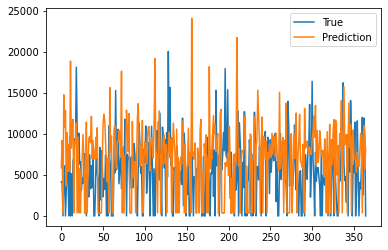

In [28]:
pred_365 = pred[0:365]
y_test_365 = y_test[0:365]

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test_365, label='True')
ax.plot(pred_365, label='Prediction')

ax.legend()
plt.show()

### 평가 : 검증 데이터로

In [29]:
pred= model.predict(x_test)

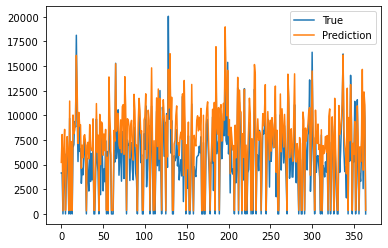

In [30]:
pred_365 = pred[0:365]
y_test_365 = y_test[0:365]

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test_365, label='True')
ax.plot(pred_365, label='Prediction')

ax.legend()
plt.show()

In [35]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, pred)
print(r2)

-648191815.4730343


In [32]:
mse = mean_squared_error(pred, y_valid, squared=False)
print(mse)

97704930.0
